In [67]:
import numpy as np
import os
import cv2
import json
import matplotlib.pyplot as plt
from utils import gaussian, tricube, colormap, quartic, triweight
from torch.utils.data import Dataset
import PIL.Image as Image
import torchvision.transforms as transforms

In [2]:
IMAGE_FOLDER = 'D:/mnt/data_source/cropped-apple-bb/images/'
GROUND_TRUTH_PATH = 'D:/mnt/data_source/cropped-apple-bb/ground-truth/ground_truth.json'

In [3]:
with open(GROUND_TRUTH_PATH) as f:
    ground_truth = json.load(f)

def get_roi(image_name):
    with open(GROUND_TRUTH_PATH) as f:
        ground_truth = json.load(f)
        
    for item in ground_truth:
        if item['name'] == image_name:
            image = cv2.imread(item['cropped_image_path'])
            
            height, width = image.shape[:2]
            coords = []
            for coord in item['crop_coordinates_ratio']:
                x, y, w, h = coord[0], coord[1], coord[2], coord[3]
                x1 = int((x - w / 2) * width)
                y1 = int((y - h / 2) * height)
                x2 = int((x + w / 2) * width)
                y2 = int((y + h / 2) * height)
                
                # Perform boundary checks
                x1 = max(0, min(x1, width - 1))
                y1 = max(0, min(y1, height - 1))
                x2 = max(0, min(x2, width - 1))
                y2 = max(0, min(y2, height - 1))
                
                coords.append((x1, y1, x2, y2))
    return coords

In [4]:
get_roi('23945062_20211025_223251_734.jpg')

[(203, 219, 373, 409),
 (284, 547, 334, 598),
 (671, 866, 716, 917),
 (768, 737, 811, 784),
 (769, 793, 810, 837)]

In [5]:
img = '23945062_20211025_200907_668.jpg'

In [59]:
def get_density_map(image_name='23945062_20211025_201041_669.jpg', sigma=10, kernel_type='gaussian', factor=3):
    
    # Load image, init density map, get coords etc.
    image = cv2.imread(f'{IMAGE_FOLDER}{image_name}')
    density_map = np.zeros(image.shape[:2], dtype=np.float32)
    coords = get_roi(image_name)
    
    for coord in coords:
        x1, y1, x2, y2 = coord
        # calculate width and height of the bounding box
        w = x2 - x1
        h = y2 - y1

        # Create 2D kernel
        kernel_size = (h, w) 
        
        if kernel_type == 'gaussian':
            kernel = gaussian(kernel_size, sigma)
        
        if kernel_type == 'tricube':
            # Pass bbox height as 'size' param for tricube
            kernel = tricube(max(h, w), factor)
            if h > w:
                kernel = kernel[:, :w]
            else:
                kernel = kernel[:h, :]
            

        # Apply kernel to density map 
        density_map[y1:y2, x1:x2] += kernel
        
    # Overlay the density_map heatmap in the original image
    overlay = colormap(density_map, image)
    # plt.axis('off')
    # plt.imshow(overlay)
        
    return overlay

In [7]:

FACTOR = 18
SIGMA = 500

In [60]:
tricube_kernel = get_density_map(img, kernel_type='tricube', factor=FACTOR)

In [9]:
gaussian_kernel = get_density_map(img, sigma=SIGMA)

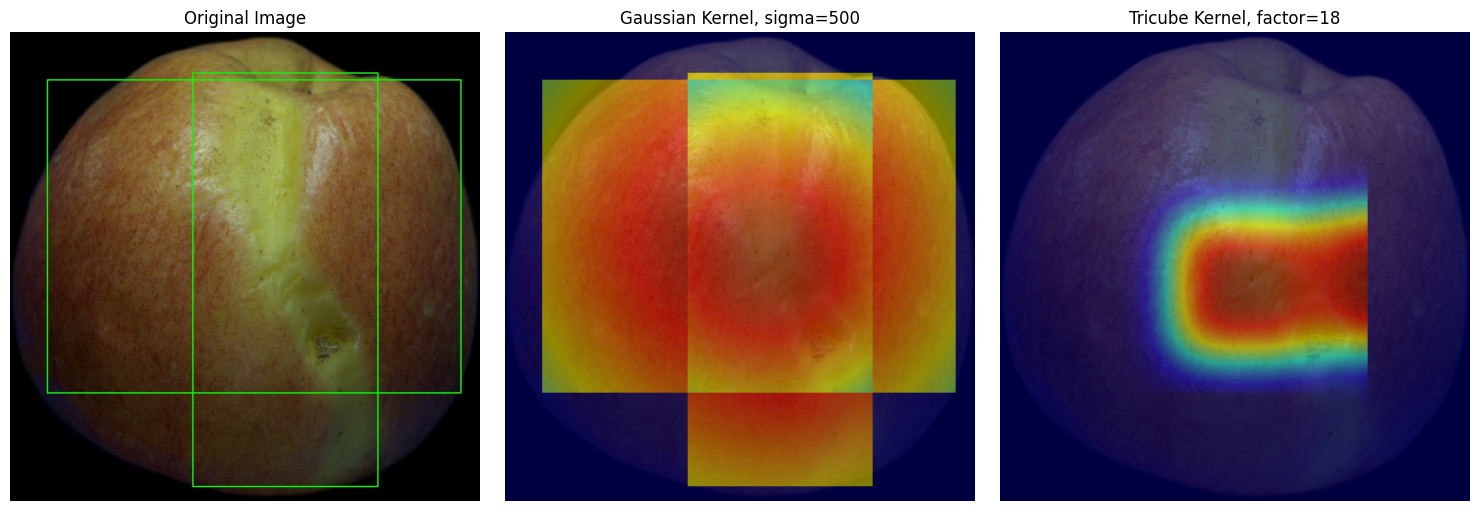

In [10]:

image_name='23945062_20211025_200907_668.jpg'

image = cv2.imread(f'D:/mnt/data_source/cropped-apple-bb/crop-images-bb/{img}')

# Plot kernels
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].imshow(image[:,:,::-1])
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(gaussian_kernel)
axs[1].set_title(f'Gaussian Kernel, sigma={SIGMA}')
axs[1].axis('off')

axs[2].imshow(tricube_kernel)  
axs[2].set_title(f'Tricube Kernel, factor={FACTOR}')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [13]:
def get_density_map(image_name='23945062_20211025_200907_668.jpg', factor=10):
    
    # Load image, init density map, get coords etc.
    image = cv2.imread(f'{IMAGE_FOLDER}{image_name}')
    density_map = np.zeros(image.shape[:2], dtype=np.float32)
    coords = get_roi(image_name)
    
    for coord in coords:
        x1, y1, x2, y2 = coord
        # calculate width and height of the bounding box
        w = x2 - x1
        h = y2 - y1

        # Create 2D kernel
        kernel = triweight(max(h, w), factor)
        if h > w:
            kernel = kernel[:, :w]
        else:
            kernel = kernel[:h, :]

        # Apply kernel to density map 
        density_map[y1:y2, x1:x2] += kernel
        
        
    # Overlay the density_map heatmap in the original image
    overlay = colormap(density_map, image)
    # plt.axis('off')
    # plt.imshow(overlay)
        
    return overlay

In [12]:
quartic_kernel = get_density_map('23945062_20211025_200907_668.jpg', factor=6)

ValueError: operands could not be broadcast together with shapes (901,403) (901,901) (901,403) 

In [24]:
triweight_kernel = get_density_map('23945062_20211025_200907_668.jpg', factor=11)

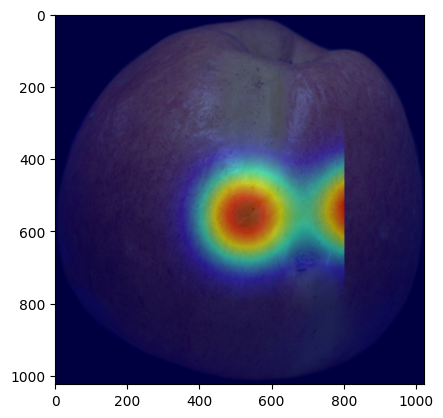

In [25]:
plt.imshow(triweight_kernel)

In [54]:
def get_density_map(image_name='23945062_20211025_201041_669.jpg', sigma=10, kernel_type='gaussian', factor=3):

    # Load image, init density map, get coords etc.
    image = cv2.imread(f'{IMAGE_FOLDER}{image_name}')
    density_map = np.zeros(image.shape[:2], dtype=np.float32)
    coords = get_roi(image_name)

    for coord in coords:
        x1, y1, x2, y2 = coord
        # calculate width and height of the bounding box
        w = x2 - x1
        h = y2 - y1
        base_map = np.zeros(image.shape[:2], dtype=np.float32)
        # Check kernel type
        if kernel_type not in ['gaussian', 'tricube']:
            raise ValueError('Invalid kernel type: {}'.format(kernel_type))

        # Create kernel
        if kernel_type == 'gaussian':
            kernel = scipy.ndimage.gaussian_filter(base_map, sigma)
        # elif kernel_type == 'tricube':
        #     kernel = scipy.ndimage.filters.gaussian_filter((max(h, w), max(h, w)), factor)

        # Apply kernel to density map
        density_map[y1:y2, x1:x2] += kernel

    # Overlay the density_map heatmap in the original image
    # ...

    return density_map


In [77]:
diameter = 400
kernel_map = tricube(diameter, 7)
kernel_poly = np.float32([[0, 0], [0, diameter], [diameter, diameter], [diameter, 0]])  # source quadrilateral coordinates

def l2_distance(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def l1_distance(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.abs(x2 - x1) + np.abs(y2 - y1)

def smoothing_mask(mask, area, box, size, label):
    H, W = mask.shape[:2]
    if type(size) is tuple:
        size = size[0] *  size[1]
    
    x1, y1, x2, y2, x3, y3, x4, y4 = box
    
    mask_w = max(l2_distance((x1, y1), (x2, y2)), l2_distance((x3, y3), (x4, y4)))
    mask_h = max(l2_distance((x1, y1), (x4, y4)), l2_distance((x2, y2), (x3, y3)))
    
    weight_mask = np.zeros((H, W), dtype=np.float32)
    mask_area = max(1, mask_w * mask_h)
    img_area = size
    
    transform_mat = cv2.getPerspectiveTransform(kernel_poly, box.reshape(4, 2))
    dst = cv2.warpPerspective(kernel_map, transform_mat, (H, W))
    
    mask_area = (img_area / mask_area)
    
    weight_mask = cv2.fillPoly(weight_mask, pts = box.astype(np.int32).reshape(1, 4, 2), color=mask_area)
    
    mask[:, :, label] = np.maximum(mask[:, :, label], dst)
    area[:, :, label] = np.maximum(area[:, :, label], weight_mask)
    
    return mask, area

In [78]:
class ImageTransform():
    def __init__(self, mode, img_size):
        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                )
            ])
    
    def __call__(self, img):
        return self.transform(img)


class AppleDataset(Dataset):
    """
    Surface Defective Apple Dataset
    Args:
        root (string): Root directory of dataset where images are stored.
    Returns:
        image (PIL Image): Image
        image path (string): Path to the image
        target (dict): The annotation
        
    """
    def __init__(self, mode, data_path, img_size=224, transform=None):
        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        self.ids = list(sorted(os.listdir(os.path.join(data_path, 'images'))))
        self.num_classes = 2
        
        # read ground truth json file
        with open(os.path.join(self.data_path, 'ground-truth','ground_truth.json')) as f:
            data = json.load(f)
        
        n = len(data)
        
        if mode == 'train':
            self.dataset = data[:int(n*0.8)]
            
        elif mode == 'test':
            self.dataset = data[int(n*0.8):]
        
        if self.transform is None:
            self.transform = ImageTransform(mode, img_size=224)
    
    
    def __len__(self):
        return len(self.dataset)
        
        
    def get_target(self, index):
        image_path = os.path.join(self.data_path, 'images', self.dataset[index]['name'])
        class_id = self.dataset[index]['class']  # 0: defective, 1: normal
        img = Image.open(image_path).convert('RGB')
        width, height = img.size
        
        temp_boxes = self.dataset[index]['crop_coordinates_ratio']
        num_objs =  len(temp_boxes)
        boxes = []
        boxes_arb = []
        
        # convert format from [cx, cy, w, h] -> [x1, y1, x2, y2]
        for box in temp_boxes:
            cx, cy, w, h = box
            xmin = int((cx - w / 2) * width)
            ymin = int((cy - h / 2) * height)
            xmax = int((cx + w / 2) * width)
            ymax = int((cy + h / 2) * height)
            
            # Perform boundary checks
            xmin = max(0, min(xmin, width - 1))
            ymin = max(0, min(ymin, height - 1))
            xmax = max(0, min(xmax, width - 1))
            ymax = max(0, min(ymax, height - 1))
            
            boxes.append([xmin, ymin, xmax, ymax, class_id])
        
        # convert format from [cx, cy, w, h] -> [x1, y1, x2, y2, x3, y3, x4, y4]
        for box in temp_boxes:
            cx, cy, w, h = box
            x1 = int((cx - w / 2) * width)
            y1 = int((cy - h / 2) * height)
            x2 = int((cx + w / 2) * width)
            y2 = int((cy - h / 2) * height)
            x3 = int((cx + w / 2) * width)
            y3 = int((cy + h / 2) * height)
            x4 = int((cx - w / 2) * width)
            y4 = int((cy + h / 2) * height)
            
            # perform boundary checks
            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            x2 = max(0, min(x2, width - 1))
            y2 = max(0, min(y2, height - 1))
            x3 = max(0, min(x3, width - 1))
            y3 = max(0, min(y3, height - 1))
            x4 = max(0, min(x4, width - 1))
            y4 = max(0, min(y4, height - 1))
            
            boxes_arb.append([x1, y1, x2, y2, x3, y3, x4, y4, class_id])
            
        # trans_img = self.transform(img)
            
        return boxes_arb, image_path, img
    
    def total_size(self, boxes):
        size_sum = 0
        for box in boxes:
            x1, y1, x2, y2, x3, y3, x4, y4 = box
            mask_w = max(l2_distance((x1, y1), (x2, y2)), l2_distance((x3, y3), (x4, y4)))
            mask_h = max(l2_distance((x1, y1), (x4, y4)), l2_distance((x2, y2), (x3, y3)))
            size_sum = size_sum + mask_w * mask_h
        return size_sum
    
    
    def __getitem__(self, index):
        boxes, image_path, img = self.get_target(index)
        height, width = img.size
        
        mask = np.zeros((self.img_size[0], self.img_size[1], self.num_classes), dtype=np.float32)
        area = np.zeros((self.img_size[0], self.img_size[1], self.num_classes), dtype=np.float32)
            
        target = np.array(target)
        
        boxes = target[:, :8]
        labels = target[:, 8]
        
        target_wh = np.array([self.img_size[1], self.img_size[0]], dtype=np.float32)
        boxes = (boxes.clip(0,1) * np.tile(target_wh, 4)).astype(np.float32)
        
        labels = labels.astype(np.int32)
        
        num_obj = len(boxes)
        total_size = self.total_size(boxes)
        
        for box, label in zip(boxes, labels):
            mask, area = smoothing_mask(mask, area, box, total_size/num_obj, label)
        
        return img, mask, area, total_size
            

In [79]:
data = AppleDataset()

TypeError: AppleDataset.__init__() missing 2 required positional arguments: 'mode' and 'data_path'

In [80]:
def get_target(img_name):
    """
    Returns the target mask and area for a given image
    Args:
        img_name (str): image name
    Returns:
        mask (np.array): target mask
        area (np.array): target area
    """
    image_path = os.path.join(self.data_path, 'images', self.dataset[index]['name'])
    class_id = self.dataset[index]['class']  # 0: defective, 1: normal
    img = Image.open(image_path).convert('RGB')
    width, height = img.size
    
    temp_boxes = self.dataset[index]['crop_coordinates_ratio']
    num_objs =  len(temp_boxes)
    boxes = []
    boxes_arb = []
    
    # convert format from [cx, cy, w, h] -> [x1, y1, x2, y2]
    for box in temp_boxes:
        cx, cy, w, h = box
        xmin = int((cx - w / 2) * width)
        ymin = int((cy - h / 2) * height)
        xmax = int((cx + w / 2) * width)
        ymax = int((cy + h / 2) * height)
        
        # Perform boundary checks
        xmin = max(0, min(xmin, width - 1))
        ymin = max(0, min(ymin, height - 1))
        xmax = max(0, min(xmax, width - 1))
        ymax = max(0, min(ymax, height - 1))
        
        boxes.append([xmin, ymin, xmax, ymax, class_id])
    
    # convert format from [cx, cy, w, h] -> [x1, y1, x2, y2, x3, y3, x4, y4]
    for box in temp_boxes:
        cx, cy, w, h = box
        x1 = int((cx - w / 2) * width)
        y1 = int((cy - h / 2) * height)
        x2 = int((cx + w / 2) * width)
        y2 = int((cy - h / 2) * height)
        x3 = int((cx + w / 2) * width)
        y3 = int((cy + h / 2) * height)
        x4 = int((cx - w / 2) * width)
        y4 = int((cy + h / 2) * height)
        
        # perform boundary checks
        x1 = max(0, min(x1, width - 1))
        y1 = max(0, min(y1, height - 1))
        x2 = max(0, min(x2, width - 1))
        y2 = max(0, min(y2, height - 1))
        x3 = max(0, min(x3, width - 1))
        y3 = max(0, min(y3, height - 1))
        x4 = max(0, min(x4, width - 1))
        y4 = max(0, min(y4, height - 1))
        
        boxes_arb.append([x1, y1, x2, y2, x3, y3, x4, y4, class_id])
        
    # trans_img = self.transform(img)
        
    return boxes_arb, image_path, img

In [81]:
DATA_PATH = 'D:/mnt/data_source/cropped-apple-bb/'
def get_annotation(img_name):
    with open(os.path.join(DATA_PATH, 'ground-truth','ground_truth.json')) as f:
        data = json.load(f)
    for item in data:
        if item['name'] == img_name:
            image_path = item['cropped_image_path']
            class_id = item['class']  # 0: defective, 1: normal
            img = Image.open(image_path).convert('RGB')
            width, height = img.size
            
            temp_boxes = item['crop_coordinates_ratio']
            num_objs =  len(temp_boxes)
            target_boxes = []

            for box in temp_boxes:
                cx, cy, w, h = box
                x1 = int((cx - w / 2) * width)
                y1 = int((cy - h / 2) * height)
                x2 = int((cx + w / 2) * width)
                y2 = int((cy - h / 2) * height)
                x3 = int((cx + w / 2) * width)
                y3 = int((cy + h / 2) * height)
                x4 = int((cx - w / 2) * width)
                y4 = int((cy + h / 2) * height)
                
                # perform boundary checks
                x1 = max(0, min(x1, width - 1))
                y1 = max(0, min(y1, height - 1))
                x2 = max(0, min(x2, width - 1))
                y2 = max(0, min(y2, height - 1))
                x3 = max(0, min(x3, width - 1))
                y3 = max(0, min(y3, height - 1))
                x4 = max(0, min(x4, width - 1))
                y4 = max(0, min(y4, height - 1))
                
                target_boxes.append([x1, y1, x2, y2, x3, y3, x4, y4, class_id])
    
    return target_boxes, image_path, img

def total_size(boxes):
    size_sum = 0
    for box in boxes:
        x1, y1, x2, y2, x3, y3, x4, y4 = box
        mask_w = max(l2_distance((x1, y1), (x2, y2)), l2_distance((x3, y3), (x4, y4)))
        mask_h = max(l2_distance((x1, y1), (x4, y4)), l2_distance((x2, y2), (x3, y3)))
        size_sum = size_sum + mask_w * mask_h
    return size_sum
    
    
def get_mask(img_name):
    target_boxes, image_path, img = get_annotation(img_name)
    height, width = img.size
    
    mask = np.zeros((height, width, 2), dtype=np.float32)
    area = np.zeros((height, width, 2), dtype=np.float32)
        
    target = np.array(target_boxes)
    
    boxes = target[:, :8]
    labels = target[:, 8]
    
    target_wh = np.array([width, height], dtype=np.float32)
    boxes = (boxes.clip(0,1) * np.tile(target_wh, 4)).astype(np.float32)
    
    labels = labels.astype(np.int32)
    
    num_obj = len(boxes)
    total_size = total_size(boxes)
    
    for box, label in zip(boxes, labels):
        mask, area = smoothing_mask(mask, area, box, total_size/num_obj, label)
    
    return img, mask, area, total_size

In [82]:
get_mask('23945062_20211025_175551_662.jpg')

UFuncTypeError: ufunc 'clip' did not contain a loop with signature matching types (dtype('<U11'), dtype('int32'), dtype('int32')) -> None